## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

The data for this project is provided by Udacity as a part of [Data Analyst Nanodegree](https://www.udacity.com/course/data-analyst-nanodegree--nd002?) program. The dataset contains results of an A/B test run by an e-commerce website.  I analyze the dataset to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

`1.` I read in the `ab_data.csv` data and store it in `df`.

a. I read in the dataset and examine the top few rows

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Number of rows in the dataset

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
mismatch1 = df[(df['group']=='treatment') \
               & (df['landing_page']=='old_page')]

In [7]:
mismatch2 = df[(df['group']=='control') \
               & (df['landing_page']=='new_page')]

In [8]:
mismatch = mismatch1['user_id'].count() + mismatch2['user_id'].count()
mismatch

3893

new_page and treatment don't match 3893 times

f. Checking to see if any of the rows have missing values

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


All the columns have 294478 non-null values. Hence, no row has missing values.

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, I cannot be sure if this row truly received the new or old page.

a. As the number of rows that mismatch (3893) are a small sample out of 294478 total rows, I will delete the rows which mismatch and store the new dataframe in **df2**.

In [10]:
df2 = df.drop(mismatch1.index)
df2 = df2.drop(mismatch2.index)

In [11]:
df2.shape

(290585, 5)

In [12]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Analyzing the dataframe **df2**

a. Number of unique **user_id**s are in **df2**

In [13]:
df2['user_id'].nunique()

290584

b. One **user_id** repeated in **df2**

In [14]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. Row information for the repeat **user_id**

In [15]:
df2[df2['user_id'].duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. I remove **one** of the rows with a duplicate **user_id**

In [16]:
df2 = df2.drop(2893)

In [17]:
df2.shape #to check no. of rows in df2

(290584, 5)

`4.` Calculating the summary statistics and probability

a. Probability of an individual converting regardless of the page they receive

In [18]:
df2['converted'].mean()

0.11959708724499628

b. Conditional probability that the individual converted given that an individual was in the `control` group

In [19]:
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

c. Conditional probability that the individual converted given that an individual was in the `treatment` group

In [20]:
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

d. Probability that an individual received the new page

In [21]:
df2.query('landing_page == "new_page"')['user_id'].count()/df2.shape[0]

0.50006194422266881

e. Based on your results from parts (a) through (d) above, is sufficient evidence to conclude that the new treatment page leads to more conversions?

There is **not sufficient** evidence to conclude that the new treatment page leads to more conversions.

The probability that the individual receives new page is 50%. This means there is a an equal probability whether the individual could receive an old page or new page.

The probability of an individual converting regardless of the page they receive is 11.96%. The probability of converting given the individual received the new page (treatment group) is 11.88%. This probability is marginally less than the probability of individual converting given they received the old page (control group) which is 12.04%.

Hence, it seems that the new page did not make any difference to the conversion rate of individuals.



<a id='ab_test'></a>
### Part II - A/B Test

As there is a time stamp associated with each event, technically hypothesis test could run continuously as each observation was observed.  

`1.` As I need to make the decision just based on all the data provided, I will assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%

I define the null and alternative hypotheses using **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Hypothesis Statement**

H0: The mean converted rate for the new page is less than or equal to the mean converted rate for the old page, i.e. $𝑝_{𝑛𝑒𝑤}$ <= $𝑝_{𝑜𝑙𝑑}$.

Alternatively, $𝑝_{𝑛𝑒𝑤}$ - $𝑝_{𝑜𝑙𝑑}$ <= 0

H1: The mean converted rate for the new page is greater than the mean converted rate for the old page, i.e. $𝑝_{𝑛𝑒𝑤}$ > $𝑝_{𝑜𝑙𝑑}$.

Alternatively, $𝑝_{𝑛𝑒𝑤}$ - $𝑝_{𝑜𝑙𝑑}$ > 0

`2.` I assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. I assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

I use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Next, I perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. The **conversion rate** for $p_{new}$ under the null

In [22]:
cr_new = df2['converted'].mean()
cr_new

0.11959708724499628

b. The **conversion rate** for $p_{old}$ under the null

In [23]:
cr_old = df2['converted'].mean()
cr_old

0.11959708724499628

c. The number of individuals in the treatment group, $n_{new}$

In [24]:
n_new = df2.query('group == "treatment"')['user_id'].count()
n_new

145310

d. The number of individuals in the control group, $n_{old}$

In [25]:
n_old = df2.query('group == "control"')['user_id'].count()
n_old

145274

e. Simulating $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Storing these $n_{new}$ 1's and 0's in **new_page_converted**.

In [26]:
new_page_converted = np.random.choice([1,0], n_new, p=[cr_new, 1-cr_new])
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

f. Simulating $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Storing these $n_{old}$ 1's and 0's in **old_page_converted**.

In [27]:
old_page_converted = np.random.choice([1,0], n_old, p=[cr_old, 1-cr_old])
old_page_converted

array([0, 0, 1, ..., 0, 0, 0])

g. Next, I calculate $p_{new}$ - $p_{old}$ for the simulated values from part (e) and (f).

In [28]:
new_page_converted.mean() - old_page_converted.mean()

-0.00071798184598828585

h. Now, I create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process used in parts (a) through (g) above and store all 10,000 values in a NumPy array called **p_diffs**.

In [29]:
# p_diffs = []
# for _ in range(10000):
#     new_page_converted = np.random.choice([1, 0], size=n_new, p=[cr_new, 1-cr_new])
#     old_page_converted = np.random.choice([1, 0], size=n_old, p=[cr_old, 1-cr_old])
#     p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

One method to create 10,000 simulations would be to run a loop. A faster method to stimulate transactions is to use np.random.binomial. 

In [30]:
new_page_converted_simulated = np.random.binomial(n_new, cr_new, 10000)/n_new
old_page_converted_simulated = np.random.binomial(n_old, cr_old, 10000)/n_old
p_diffs = new_page_converted_simulated - old_page_converted_simulated

In [31]:
p_diffs

array([ -1.28222271e-03,  -1.06901020e-03,  -1.59887256e-03, ...,
        -8.48305040e-05,  -3.65911227e-05,  -2.77694234e-04])

i. I plot a histogram of the **p_diffs** to see if it looks like what I expected

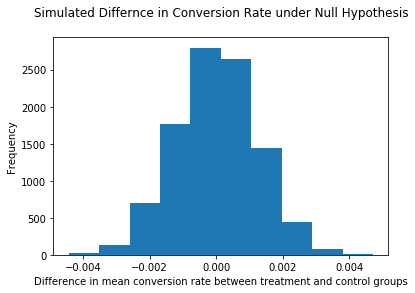

In [32]:
plt.hist(p_diffs)
plt.title('Simulated Differnce in Conversion Rate under Null Hypothesis\n', fontsize = 12)
plt.xlabel('Difference in mean conversion rate between treatment and control groups')
plt.ylabel('Frequency');

As expected, the simulated difference in conversion rate under null hypothesis follows a normal distribution.

j. Calculating the proportion of the **p_diffs** that are greater than the actual difference observed in **ab_data.csv**

In [33]:
df_control = df2.query('group == "control"')
df_treatment = df2.query('group == "treatment"')

# Actual difference observed between the conversion rate for new page and old page
obs_diff = df_treatment.converted.mean() - df_control.converted.mean()
obs_diff

-0.0015782389853555567

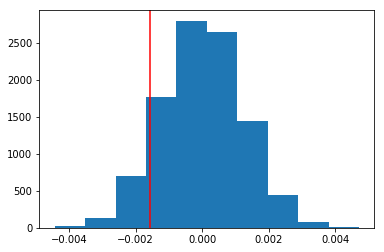

In [34]:
plt.hist(p_diffs)
plt.axvline(obs_diff, color='r');

In [35]:
p_value = (p_diffs > obs_diff).mean()
p_value

0.90159999999999996

In [36]:
print(f'{p_value*100}% of the p_diffs are greater than the actual difference observed in ab_data.csv')

90.16% of the p_diffs are greater than the actual difference observed in ab_data.csv


k. Interpreting the results

p value is the probability of observing our statistic in favor of alternative hypothesis if null hypothesis is true.

Since the p value (0.90) is greater than the threshold for Type I error rate of 0.05, we fail to reject the Null Hypothesis.

The conversion rate for the new page is less than or equal to the conversion rate for old page.

l. Using statsmodel Python package to test the hypothesis. 

I calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [37]:
import statsmodels.api as sm

convert_old = df2.query('group=="control"')['converted'].sum()
convert_new = df2.query('group=="treatment"')['converted'].sum()
n_old = df2.query('group=="control"')['user_id'].count()
n_new = df2.query('group=="treatment"')['user_id'].count()
print('Number of conversions for old page is {} \nand the number of conversions for new page is {}'\
      .format(convert_old, convert_new))
print('\n')
print('Number of users who receive old page is {} \nand number of users who receive new page is {}'\
      .format(n_old, n_new))

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Number of conversions for old page is 17489 
and the number of conversions for new page is 17264


Number of users who receive old page is 145274 
and number of users who receive new page is 145310


m. I use use `stats.proportions_ztest` to compute the test statistic and p-value

In [38]:
# For one-sided z-test, alternative is selected as 'larger' as the alternative hypothesis is of the form  prop > value
stat, pval = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
print(f'The value of statistic for z-test (or z-score) is {stat} \nand p value for the z-test is {pval}')

The value of statistic for z-test (or z-score) is -1.3109241984234394 
and p value for the z-test is 0.9050583127590245


In [39]:
from scipy.stats import norm

print(f'z-critival value is {norm.ppf(1-(0.05))}') # Tells us the critical value at 95% confidence interval

z-critival value is 1.6448536269514722


n. Interpretation of the z-score and p-value

For alpha level, 0.05, the z-critical value is 1.65. Since, z-score (-1.31) is less than the z-critical value, we fail to reject the Null Hypothesis.

The p value is greater than the alpha level (0.05). Therefore, we fail to reject the Null Hypothesis.
There is no significant evidence that the new page is better than the old page.
The analysis is similar to the analysis performed in part j. and k.